### Overview

My goal for this project is to implement text classification for restaurant reviews on Grubhub to understand whether the review is about the food or the delivery experience. In the past, I've noticed that many of the bad reviews on platforms like these are actually due to a bad delivery experience, which is often not the fault of the restaurant. For small businesses, this handful of bad reviews can be a detriment to their success on a platform like Grubhub, Doordash, or Uber Eats. 

Additionally, as a customer, I would value the ability to understand how a restaurant scores across multiple categories, not just in aggregate.

One aspect of this project I was very curious about was whether I'd be able to generate predictions using an unsupervised approach. In this case, since I am scraping reviews from Grubhub myself, I would also need to label the data, which is unrealistic across a sample size this large.

After some research, I came across [Lbl2Vec](https://github.com/sebischair/Lbl2Vec) which provides "an algorithm for unsupervised document classification and unsupervised document retrieval". Sounds like exactly what I need! Lbl2Vec works by referencing a list of predefined categories, the sample text, and its understanding of language/similarities between words. Using these components, the algorithm can decide which category is most appropriate for the sample text.

### Data Collection/Cleansing

Using a combination of Beautiful Soup, Selenium, and the WebScraper web extension, I pulled reviews from 50 restaurants in my area, with a total of about 8,500 reviews. Based on my past experience, this is a small dataset to use for NLP, but I wanted to start with a simple baseline to understand if this was viable.

It is worth noting as well that I did spend about 20 minutes manually labeling roughly 300 randomly selected reviews with categories in order to evaluate model accuracy.

In [1]:
from lbl2vec import Lbl2Vec

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import strip_tags
from gensim.models.doc2vec import TaggedDocument

import plotly.express as px

/Users/brianmcniff/opt/anaconda3/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
def parse_reviews(csv_file_path):
    # one row per review, includes small percent of manually tagged categories
    reviews = pd.read_csv(csv_file_path)
    reviews.columns = ['review_id', 'store_url', 'stars_raw', 'text', 'word_count', 'class_name']

    # remove comments manually tagged as 'multi' (multiple categories in one comment)
    reviews = reviews[reviews['class_name']!='multi']

    # partition train/test based on presence of manual tagging
    train = reviews[pd.isna(reviews['class_name'])]
    test = reviews[~pd.isna(reviews['class_name'])]

    # add data set type column
    train['data_set_type'] = 'train'
    test['data_set_type'] = 'test'

    # concat train and test data
    corpus = pd.concat([train,test]).reset_index(drop=True)
    
    return corpus

corpus = parse_reviews('/Users/brianmcniff/Downloads/grubhub_reviews.csv')

In addition to text data, Lbl2Vec also requires a manually specified list of categories. As shown below, each category is actually defined by its keywords. In my opinion, tweaking these categories ended up being the most interesting part of the project, and will get into details later.

For this project, I decided a good goal was to determine whether a review was about the quality of the food, the delivery experience, or the accuracy of the order, and did my best to come up with some relevant words using out of sample reviews as inspiration.

In [4]:
#dict of manually specified category/tag pairs
labels_dict = {
    'quality': ['old', 'burnt', 'soggy', 'burn', 'best', 'full', 'incredible', 'excellent', 'fresh', 'gross', 'tasty', 'spicy', 'dry', 'frozen', 'hard', 'awesome', 'excellent', 'mushy', 'delicious', 'delish', 'options'],
    'delivery': ['hour', 'late', 'time', 'minutes', 'late', 'lost', 'directions', 'instructions', 'outside', 'door', 'floor', 'stairs', 'downstairs', 'lobby', 'porch', 'leave'],
    'accuracy': ['missing', 'item', 'incomplete', 'forgot', 'correct']
}

# creation of label dataframe
def parse_labels(labels_dict):
    labels_list = [[cat, tags, len(tags)] for cat, tags in labels_dict.items()]
    labels = pd.DataFrame(labels_list, columns = ['class_name', 'keywords', 'number_of_keywords'])
    labels = labels.reset_index()
    
    return labels

labels = parse_labels(labels_dict)

### Making Predictions

At this point, we have all of the data we'll need to make predictions. I found a very helpful [article](https://towardsdatascience.com/unsupervised-text-classification-with-lbl2vec-6c5e040354de) published by the creator of the library, which runs through a simple demonstration. I used this as a jumping off point to create a function which tokenizes and tags documents, as well as a function which tests the model on our manually tagged dataset to understand how well it performs.

My goal in keeping each of these steps of the process modularized is to enable quick and easy iteration, as I suspect model tuning will be a significant part of this process. Let's try running this and see how our first attempt goes.

In [21]:
def tokenize_and_tag(corpus):
# tokenize and tag documents for Lbl2Vec training
    corpus['tagged_docs'] = corpus.apply(lambda row: TaggedDocument(simple_preprocess(strip_tags(row['text']), deacc=True, min_len=3, max_len=15), [str(row.name)]), axis=1)

    # add doc_key column
    corpus['doc_key'] = corpus.index.astype(str)

    return corpus

corpus = tokenize_and_tag(corpus)

# init model with parameters
Lbl2Vec_model = Lbl2Vec(keywords_list=list(labels.keywords),
                        tagged_documents=corpus['tagged_docs'][corpus['data_set_type'] == 'train'],
                        label_names=list(labels.class_name),
                        vector_size = 300,
                        min_count = 50,
                        window = 15,
                        similarity_threshold=0.3,
                        epochs=50,
                        verbose=False)

# train model
Lbl2Vec_model.fit()

def test_and_score(model, test_data):
    test_reviews = model.predict_new_docs(tagged_docs=test_data['tagged_docs'])
    
    # merge DataFrames to compare the predicted and true topic labels
    evaluation_test = test_reviews.merge(test_data, left_on='doc_key', right_on='doc_key')
    y_true_test = evaluation_test['class_name']
    y_pred_test = evaluation_test['most_similar_label']
    
    return f1_score(y_true_test, y_pred_test, average='weighted'), confusion_matrix(y_true_test, y_pred_test)

test_and_score(Lbl2Vec_model, corpus[corpus['data_set_type']=='test'])

2023-09-21 18:05:47,950 - Lbl2Vec - WARNING - The following keywords from the 'keywords_list' are unknown to the Doc2Vec model and therefore not used to train the model: gross plain vegetables
2023-09-21 18:05:47,950 - Lbl2Vec - WARNING - The following keywords from the 'keywords_list' are unknown to the Doc2Vec model and therefore not used to train the model: gross plain vegetables
2023-09-21 18:05:47,950 - Lbl2Vec - WARNING - The following keywords from the 'keywords_list' are unknown to the Doc2Vec model and therefore not used to train the model: gross plain vegetables
2023-09-21 18:05:47,950 - Lbl2Vec - WARNING - The following keywords from the 'keywords_list' are unknown to the Doc2Vec model and therefore not used to train the model: gross plain vegetables
2023-09-21 18:05:47,950 - Lbl2Vec - WARNING - The following keywords from the 'keywords_list' are unknown to the Doc2Vec model and therefore not used to train the model: gross plain vegetables
2023-09-21 18:05:47,950 - Lbl2Vec -

(0.48570916526775326,
 array([[ 2, 28, 11],
        [ 7, 47, 19],
        [10, 64, 83]]))

### Initial Results and Tuning

I'd interpret this as a rather mediocre F1 score (it's worth noting that since we have three classes, random guessing would be ~33%). It's clear to me that "delivery" (second row) predictions are performing the strongest, while "order accuracy" (first row) predictions are rather poor. Typically I would assume this would be due to class imbalance in the training data, but here it's difficult to know that due to the unsupervised nature of this algorithm, and the absence of labeled data. It looks like a lot of the "food quality" reviews are being interpreted as "delivery" so I'll be keeping an eye on this throughout the hyperparameter tuning process as well. 

I also want to tweak the keywords a bit to hopefully nudge some of the "food quality" and "accuracy" examples into the correct category, though I suspect that will come as a trade off to overall accuracy.

After a bit of experimenting, I found that running this model at 50 epochs allowed for a good trade off between accuracy and time, so I'll test a few parameters at 50 epochs and see what we find.

In [ ]:
# vector_size_options = [200, 300, 400]
# min_count_options = [5, 10, 20, 30]
# window_options = [10, 15, 25]
# similarity_threshold_options = [0.8, 0.9, 0.99]

# scores = pd.DataFrame(columns = ['Vector Size', 'Min Count', 'Window Options', 'Similarity Threshold', 'F1 Score'])

# for vs in vector_size_options:
#     for mc in min_count_options:
#         for w in window_options:
#             for st in similarity_threshold_options:
#                 Lbl2Vec_model = Lbl2Vec(keywords_list=list(labels.keywords),
#                     tagged_documents=corpus['tagged_docs'][corpus['data_set_type'] == 'train'],
#                     label_names=list(labels.class_name),
#                     vector_size=vs,
#                     min_count = mc,
#                     window = w,
#                     similarity_threshold=st,
#                     epochs=50,
#                     verbose=False)

#                 # train model
#                 Lbl2Vec_model.fit()
#                 f1 = test_and_score(Lbl2Vec_model, corpus[corpus['data_set_type']=='test'])[0]
                
#                 scores.loc[len(scores)] = [vs, mc, w, st, f1]

# scores.sort_values('F1 Score', ascending=False)

### Hyperparameter Tuning

It looks like our best combination of parameters is:
- vector_size = 300
- min_count = 20
- window = 15
- similarity_threshold=0.8

This provided an F1 score of 0.72.

While this is a large improvement, I do feel a little hesitant to follow this completely for a few reasons. I'm noticing after seeing many iterations of this model that the F1 score is very volatile. Even running the same model with the exact same parameters can swing by 5% each time. I've put some time into troubleshooting this by specifying random and numpy.random seeds, but it looks as though the non-deterministic properties of this algorithm are due to a different library. This makes hyperparameter tuning a bit unreliable.

Alternatively, what I have found helpful is tweaking the keywords used to define the categories. I have noticed consistent improvements by choosing less keywords for each category and ensuring they're not only related to the category, but not related to any of the others. This is critical because of the homogeneity of our vocabulary (every data point is about food). This has been a really interesting component to work on as it feels rather unique compared to more traditional parts of the predictive modeling process. Here is the final list I ended up using:

In [24]:
labels_dict = {
    'quality': ['fresh', 'taste', 'delicious', 'gross', 'great', 'plain', 'chicken', 'pasta', 'vegetables'],
    'delivery': ['cold', 'driver', 'late', 'lost', 'delivered', 'delivery'],
    'accuracy': ['forgot', 'missing', 'wrong']
}

labels = parse_labels(labels_dict)

One last point I'd like to make is that it is not at all uncommon to see a review that mentions both or all three categories. While this model is outputting the single most relevant category right now, it also outputs the % match to each category meaning that with some tweaking, we could return any categories that cross a particular threshold, allowing for multiple tagged categories per review. Perhaps in a part 2 of this post. :)

### Visualizing Performance

The last part of this project that I'm very interested in is visualizing a restaurant's performance across these three categories. Now that we can estimate which category a review is discussing, we just need an understanding of the restaurant's performance in that category. For this reason, I also pulled the star rating of each review. For example, we can assume that if a review is about delivery and is given 2 stars, the customer did not have a good delivery experience.

While we can likely communicate this information using a bar chart or box and whisker plot, I'm curious to see how this information can be visualised using a polar chart. Let's start by training the model one last time with our final parameters and keyword sets, and then make predictions across our entire dataset.

In [25]:
Lbl2Vec_model = Lbl2Vec(keywords_list=list(labels.keywords),
                        tagged_documents=corpus['tagged_docs'][corpus['data_set_type'] == 'train'],
                        label_names=list(labels.class_name),
                        vector_size = 300,
                        min_count = 20,
                        window = 15,
                        similarity_threshold=0.99,
                        epochs=100,
                        verbose=False)

Lbl2Vec_model.fit()

print(test_and_score(Lbl2Vec_model, corpus[corpus['data_set_type']=='test']))

# predict categories
train_reviews = Lbl2Vec_model.predict_model_docs()

reviews_w_cat = train_reviews.merge(corpus[corpus['data_set_type'] == 'train'], left_on='doc_key', right_on='doc_key')

(0.7151600262637334, array([[ 27,   9,   5],
       [ 12,  52,   9],
       [ 33,  14, 110]]))


In [10]:
# map raw html attributes to star ratings
reviews_w_cat['store'] = [url.split('/')[4] for url in reviews_w_cat['store_url']]
reviews_w_cat['stars'] = reviews_w_cat['stars_raw'].map({'background-position: 0px -192px;': 5, 
                           'background-position: 0px -144px;': 4,
                           'background-position: 0px -96px;': 3,
                           'background-position: 0px -48px;': 2,
                           'background-position: 0px 0px;': 1})

/Users/brianmcniff/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/brianmcniff/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/brianmcniff/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



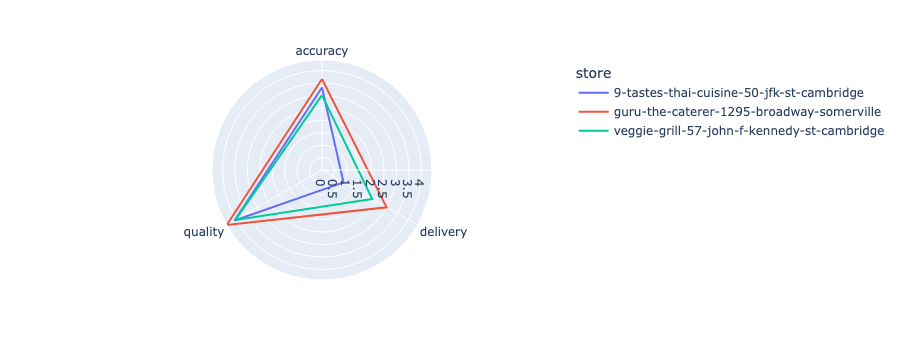

In [22]:
polar_df = reviews_w_cat[['store', 'most_similar_label', 'stars']].groupby(['store', 'most_similar_label']).mean()
polar_df = polar_df.reset_index()

example_restuarants = polar_df[
    (polar_df.store == 'guru-the-caterer-1295-broadway-somerville') | 
    (polar_df.store == '9-tastes-thai-cuisine-50-jfk-st-cambridge') |
    (polar_df.store == 'veggie-grill-57-john-f-kennedy-st-cambridge')][['store', 'most_similar_label', 'stars']]
fig = px.line_polar(example_restuarants, r = 'stars', theta = 'most_similar_label', line_close = True, color='store')

fig.show()

### Closing Thoughts
There are a couple of things I notice with this visualization - the first is that it intuitively shows the overall quality of a restaurant, and allows one to compare overall qualities by comparing overall areas. However there are definitely many benefits that a traditional grouped bar chart would have over this. Regardless, it's interesting to see the data displayed in this way!

It's been interesting to see that delivery scores are almost always the lowest, followed by accuracy, and then quality. This makes perfect sense to me as many people will have nothing to say if their order was on time and accurate. For this same exact reason, it was actually hard to find terms that were positive or neutral to include for delivery/accuracy keywords.

Speaking about this model more generally, I'm very surprised to see the scores it's able to achieve given a small sample size, and what I think is a very difficult problem to solve - distinguishing between categories within a single topic. As next steps to improve this model, I would definitely invest more time in collecting data (likely an order of magnitude or more), revisit hyperparameter tuning, and perhaps rework the algorithm to output multiple categories where appropriate.

For now though, I will leave this project here. If you're interested in running this code for restaurants near you, here is a Google Colab notebook with all of the code above.